# Find the best average fold run

In [51]:
import pandas as pd

df = pd.read_csv('data/fold_results.csv')

# Filter rows where 'Fold' is 'Average' and 'Final Model' is not 1
average_rows = df[(df['Fold'] == 'Average') & (df['Final Model'] != 1)]

best_f1_row = average_rows.loc[average_rows['F1'].idxmax()]
best_run_id = best_f1_row['Run ID']
print(best_f1_row)

print(best_run_id)

Fold                             Average
Run ID           20240630085259_1007361e
Final Model                            0
Best Loss                       0.477272
Loss                            0.477272
Accuracy                        0.874074
F1                               0.88171
Num Classes                            9
Input Size                            12
Hidden Size                          100
Num Layers                             2
Output Size                            1
Num Epochs                           600
Learning Rate                   0.000179
Batch Size                            32
Name: 10, dtype: object
20240630085259_1007361e


In [42]:
def get_hyperparameters_for_average_run(df, run_id):
    run_data = df[df['Run ID'] == run_id]

    if not run_data.empty:
        first_row = run_data.iloc[0]
        # Extract the hyperparameters
        hyperparameters = (
            first_row['Num Classes'],
            first_row['Input Size'],
            first_row['Hidden Size'],
            first_row['Num Layers'],
            first_row['Output Size'],
            first_row['Num Epochs'],
            first_row['Learning Rate'],
            first_row['Batch Size']
        )
        return hyperparameters
    else:
        return "Run ID not found."

In [43]:
ideal_hyperparameters = get_hyperparameters_for_average_run(df, best_run_id)
print(ideal_hyperparameters)

(9, 12, 100, 2, 1, 600, 0.000179, 32)


In [21]:
def find_runs_with_hyperparameters(df, hyperparameters):
    num_classes, input_size, hidden_size, num_layers, output_size, num_epochs, learning_rate, batch_size = hyperparameters
    
    # Filter the DataFrame for rows matching all specified hyperparameters
    matching_runs = df[
        (df['Num Classes'] == num_classes) &
        (df['Input Size'] == input_size) &
        (df['Hidden Size'] == hidden_size) &
        (df['Num Layers'] == num_layers) &
        (df['Output Size'] == output_size) &
        (df['Num Epochs'] == num_epochs) &
        (df['Learning Rate'] == learning_rate) &
        (df['Batch Size'] == batch_size)
    ]
    
    # Extract the 'Run ID' column from the filtered DataFrame and remove duplicates
    run_ids = tuple(matching_runs['Run ID'].unique())
    
    return run_ids


hyperparameters = (9, 12, 100, 2, 1, 600, 0.000179, 32)  # Replace this with the hyperparameters you're interested in
matching_run_ids = find_runs_with_hyperparameters(df, hyperparameters)
print(matching_run_ids)

('20240630085259_1007361e', '20240630095903_eec6aa6e')


       Fold Index  Epoch       mean  std                   Run ID
0               1      1  17.581035  NaN  20240630085259_1007361e
1               1      2   3.670644  NaN  20240630085259_1007361e
2               1      3   3.757455  NaN  20240630085259_1007361e
3               1      4   3.686837  NaN  20240630085259_1007361e
4               1      5   3.652950  NaN  20240630085259_1007361e
...           ...    ...        ...  ...                      ...
13195          10    596   1.450283  NaN  20240630095903_eec6aa6e
13196          10    597   1.516001  NaN  20240630095903_eec6aa6e
13197          10    598   1.504316  NaN  20240630095903_eec6aa6e
13198          10    599   1.552792  NaN  20240630095903_eec6aa6e
13199          10    600  17.587584  NaN  20240630095903_eec6aa6e

[13200 rows x 5 columns]


<Axes: xlabel='Epoch', ylabel='mean'>

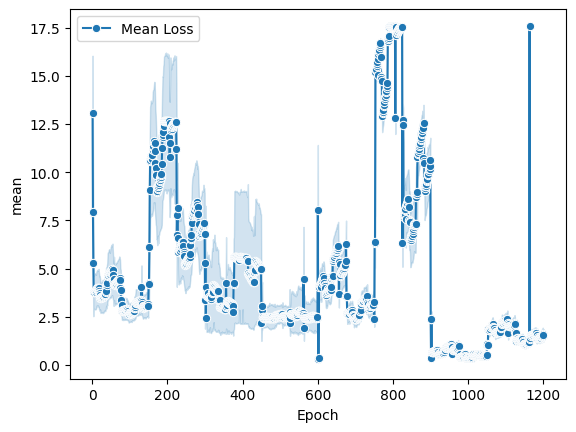

In [50]:
def get_loss_stats_folds(run_ids):
    df = pd.read_csv("data/fold_detailed_losses.csv")

    aggregated_stats = pd.DataFrame()
    
    for run_id in run_ids:
        df_run = df[df['Run ID'] == run_id]
        df_run = df_run.sort_values(by=['Fold Index'])
        df_run['Epoch'] = df_run.groupby(['Run ID', 'Fold Index']).cumcountZ() + 1
        
        stats_per_fold_epoch = df_run.groupby(['Fold Index', 'Epoch'])['Loss'].agg(['mean', 'std']).reset_index()
        stats_per_fold_epoch['Run ID'] = run_id
    
        aggregated_stats = pd.concat([aggregated_stats, stats_per_fold_epoch], ignore_index=True)
    
    return aggregated_stats

data = get_loss_stats_folds(matching_run_ids)
print(data)
sns.lineplot(x='Epoch', y='mean', data=data, marker='o', label='Mean Loss')

   Fold                   Run ID  Accuracy
11    0  20240630085259_1007361e  0.843243
71    0  20240630095903_eec6aa6e  0.883784


<Axes: xlabel='Run ID', ylabel='Accuracy'>

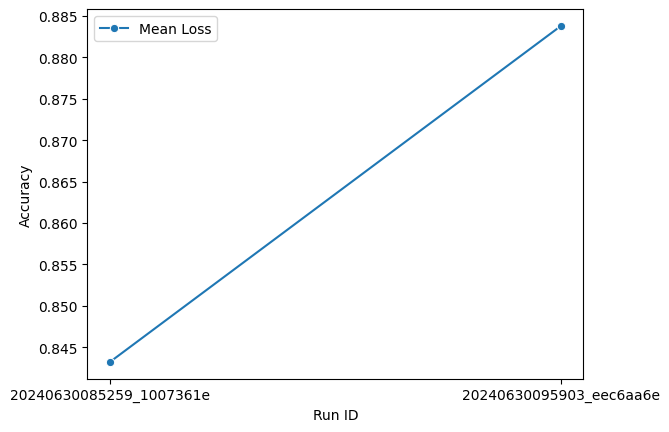

In [60]:
def get_accuracy_stats_folds(run_ids):
    df = pd.read_csv("data/fold_results.csv")  # Ensure this CSV also contains an 'Accuracy' column

    # Filter rows where 'Final Model' is 1
    df_final_models = df[df['Final Model'] == 1]

    # Filter for the specified run IDs
    df_filtered = df_final_models[df_final_models['Run ID'].isin(run_ids)]
    
    # Select only the necessary columns for plotting
    accuracy_data = df_filtered[['Fold', 'Run ID', 'Accuracy']]
    
    return accuracy_data


# Example usage
accuracy_data = get_accuracy_stats_folds(matching_run_ids)
print(accuracy_data.head(5))
sns.lineplot(x='Run ID', y='Accuracy', data=accuracy_data, marker='o', label='Mean Loss')

   Fold                   Run ID        F1
11    0  20240630085259_1007361e  0.843829
71    0  20240630095903_eec6aa6e  0.884774


<Axes: xlabel='Run ID', ylabel='F1'>

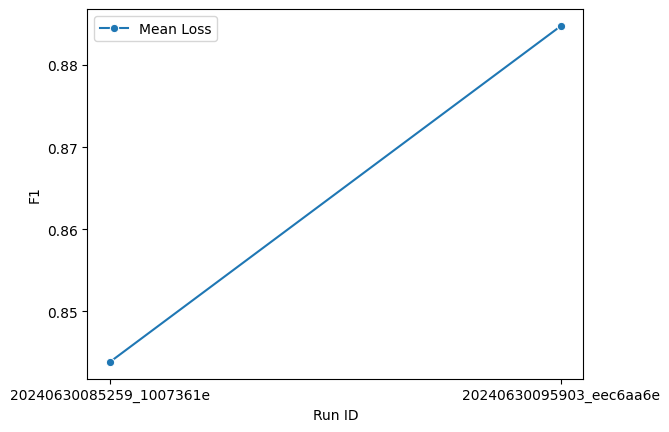

In [61]:
def get_f1_stats_folds(run_ids):
    df = pd.read_csv("data/fold_results.csv")  # Ensure this CSV also contains an 'Accuracy' column

    df_final_models = df[df['Final Model'] == 1]

    # Filter for the specified run IDs
    df_filtered = df_final_models[df_final_models['Run ID'].isin(run_ids)]
    
    # Select only the necessary columns for plotting
    f1_data = df_filtered[['Fold', 'Run ID', 'F1']]
    
    return f1_data


# Example usage
accuracy_data = get_f1_stats_folds(matching_run_ids)
print(accuracy_data.head(5))
sns.lineplot(x='Run ID', y='F1', data=accuracy_data, marker='o', label='Mean Loss')

    Learning Rate        F1
10       0.000179  0.881710
22       0.000058  0.661093
34       0.000200  0.839489
46       0.000170  0.823380
58       0.000165  0.842551


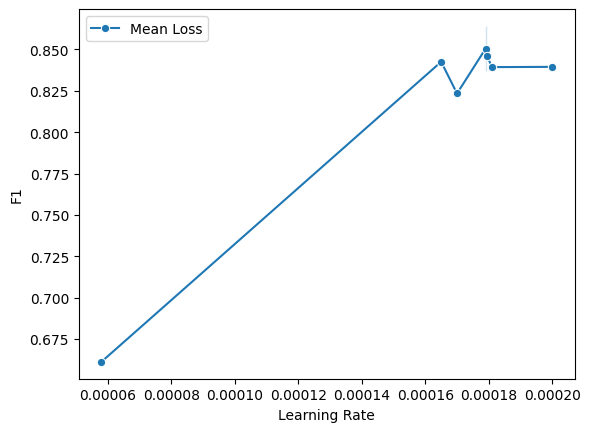

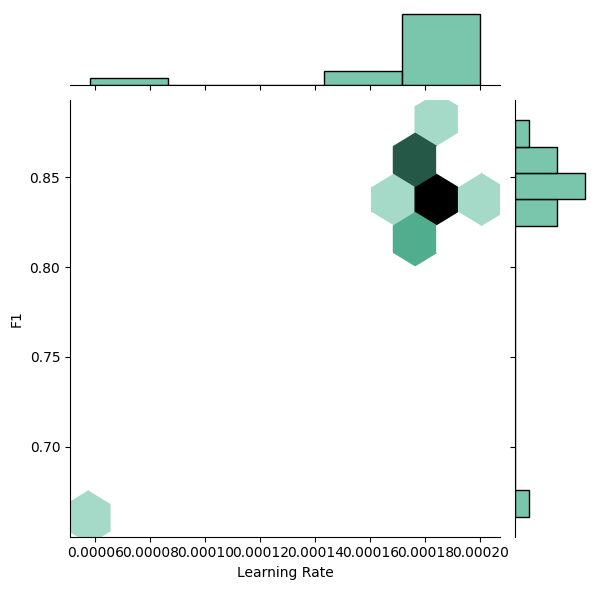

In [65]:
# DO HYPER-PARAMETER COMPARISON

def get_f1_vs_learning_rate():
    df = pd.read_csv("data/fold_results.csv")
    df_average = df[df['Fold'] == 'Average']
    df_lr_vs_f1 = df_average[['Learning Rate', 'F1']]
    
    return df_lr_vs_f1

def get_f1_vs_learning_rate():
    df = pd.read_csv("data/fold_results.csv")
    df_average = df[df['Fold'] == 'Average']
    df_lr_vs_f1 = df_average[['Learning Rate', 'F1']]
    
    return df_lr_vs_f1

def get_f1_vs_learning_rate():
    df = pd.read_csv("data/fold_results.csv")
    df_average = df[df['Fold'] == 'Average']
    df_lr_vs_f1 = df_average[['Learning Rate', 'F1']]
    
    return df_lr_vs_f1



f1_tuning = get_f1_vs_learning_rate()
print(f1_tuning.head(5))
sns.lineplot(x='Learning Rate', y='F1', data=f1_tuning, marker='o', label='Mean Loss')

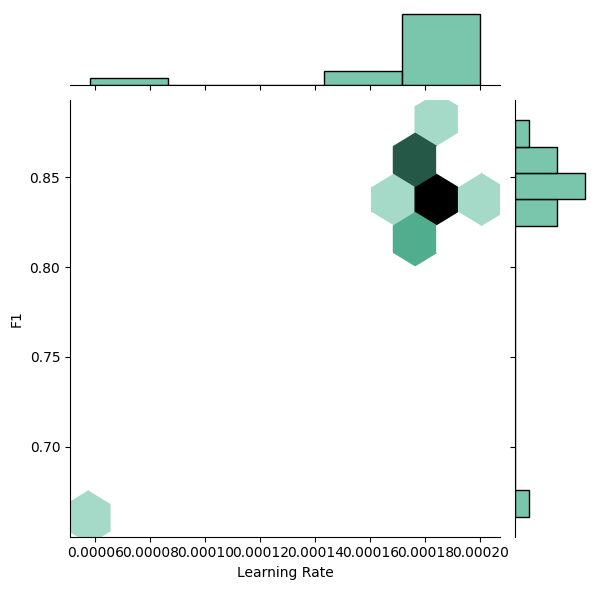

In [66]:
sns.jointplot(x='Learning Rate', y='F1', data=f1_tuning, kind="hex", color="#4CB391")